# Working With Elections Data

In [1]:
# Inline Chart Parameters
%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import pandas as pd
import numpy as np
import us
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Today's Datasets
- Election Results
    - [Presidential Results Compiled by DailyKos (via U.S. ElectionAtlas)](https://docs.google.com/spreadsheets/d/1D-edaVHTnZNhVU840EPUhz3Cgd7m39Urx7HM8Pq6Pus/edit#gid=29622862)
    - [Presidential Results @ County Level for 2016 - US Election Atlas]()
- [Polls](https://github.com/fivethirtyeight/data/tree/master/pollster-ratings)
- [Pollster Ratings](https://github.com/fivethirtyeight/data/tree/master/pollster-ratings)

## Election Results

### PVI

In [2]:
pres_results = pd.read_csv('pres_results.csv')
pres_results['d_margin'] = pres_results.dem - pres_results.rep

pres_results_national = pres_results[pres_results.state == 'US']
pres_results_by_state = pres_results[~pres_results.state.isin(['DC','US'])]

pres_results_national.head()

,year,state,dem,rep,d_margin
44,2016,US,51.1,48.9,2.2
96,2012,US,52.0,48.0,4.0
148,2008,US,53.7,46.3,7.4
200,2004,US,48.8,51.2,-2.4
252,2000,US,50.3,49.7,0.6


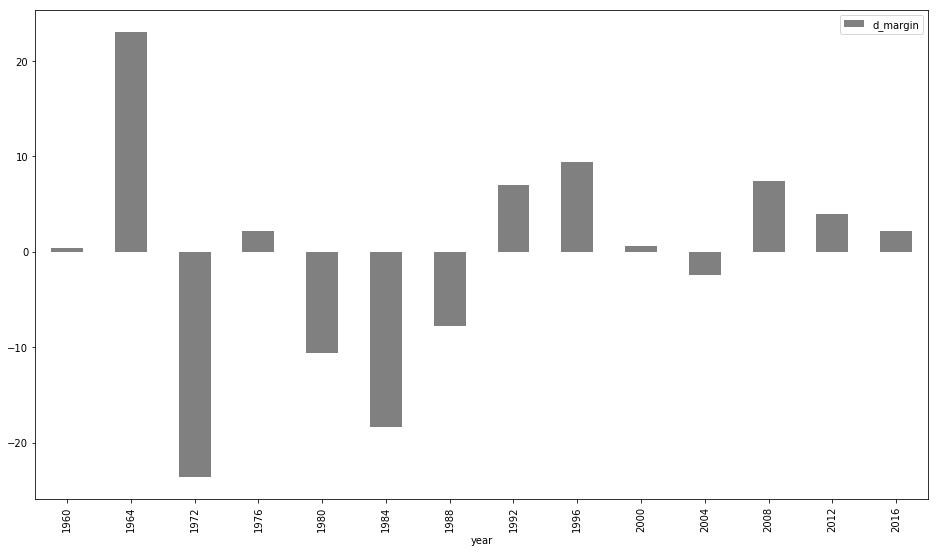

In [3]:
pres_results_national.sort_values(by='year').plot(
    x='year', y='d_margin', kind='bar', color='grey');

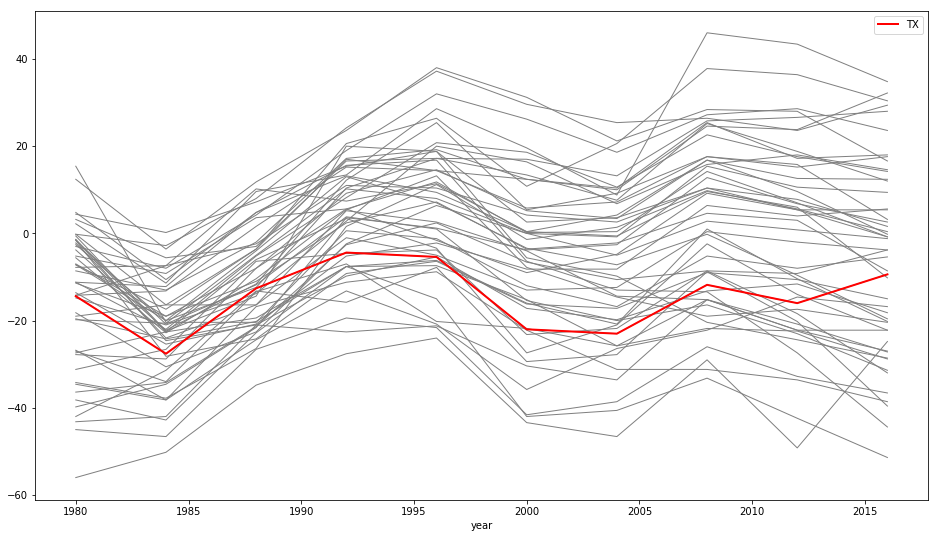

In [4]:
fig, ax = plt.subplots()
pres_results_by_state[pres_results_by_state.year>=1980].groupby('state').plot(
    x='year', y='d_margin', c='grey', kind='line', ax=ax, legend=False, linewidth=1);
pres_results_by_state[(pres_results_by_state.year>=1980)&(pres_results_by_state.state=='TX')].plot(
    x='year', y='d_margin', c='red', kind='line', ax=ax, label='TX', linewidth=2);

In [5]:
df = pres_results_by_state

df['previous_year'] = df.year - 4

df = pd.merge(
    df, 
    pres_results_by_state[['year','state','rep', 'dem']],
    how='left', left_on=('previous_year', 'state'), right_on=('year', 'state'), suffixes=('','_previous_year'))

df = pd.merge(
    df, 
    pres_results_national[['year','rep', 'dem']],
    how='left', on='year', suffixes=('','_national'))

df = pd.merge(
    df, 
    pres_results_national[['year','rep', 'dem']],
    how='left', left_on='previous_year', right_on='year', suffixes=('','_previous_year_national'))

del df['year_previous_year_national']
del df['year_previous_year']

df['pvi'] = (df['rep'] * .5 + df['rep_previous_year'] * .5 ) - (df['rep_national'] *.5 + df['rep_previous_year_national'] * .5)
df['fte_pvi'] = (df['rep'] * .75 + df['rep_previous_year'] * .25 ) - (df['rep_national'] *.75 + df['rep_previous_year_national'] * .25)

df = df[df.year>=1980]

df[df['year'] == 2016].head(n=5)

,year,state,dem,rep,d_margin,previous_year,rep_previous_year,dem_previous_year,rep_national,dem_national,rep_previous_year_national,dem_previous_year_national,pvi,fte_pvi
0,2016,AK,41.6,58.4,-16.8,2012,57.3,42.7,48.9,51.1,48.0,52.0,9.40,9.450
1,2016,AL,35.6,64.4,-28.8,2012,61.2,38.8,48.9,51.1,48.0,52.0,14.35,14.925
2,2016,AR,35.7,64.3,-28.6,2012,62.2,37.8,48.9,51.1,48.0,52.0,14.80,15.100
3,2016,AZ,48.1,51.9,-3.8,2012,54.6,45.4,48.9,51.1,48.0,52.0,4.80,3.900
4,2016,CA,66.1,33.9,32.2,2012,38.1,61.9,48.9,51.1,48.0,52.0,-12.45,-13.725


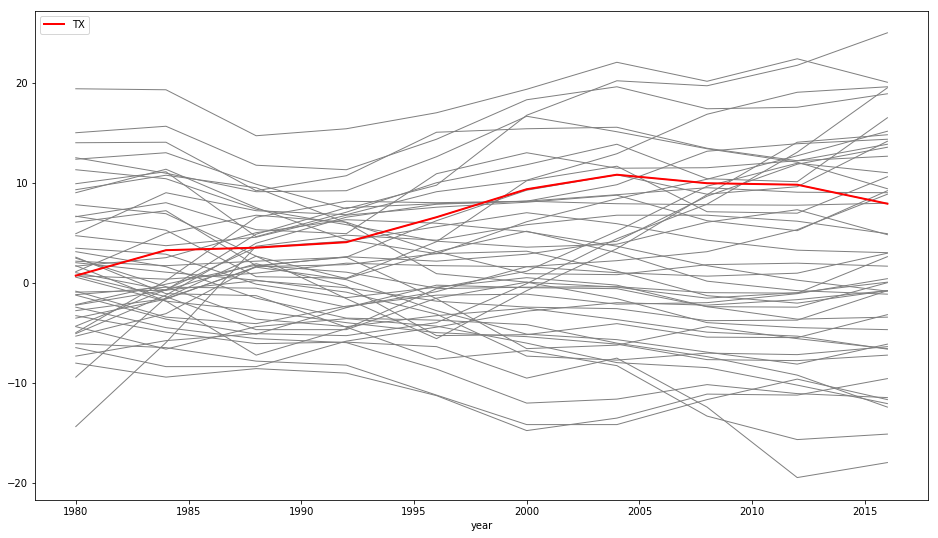

In [6]:
fig, ax = plt.subplots()
df.groupby('state').plot(
    x='year', y='pvi', c='grey', kind='line', ax=ax, legend=False, linewidth=1);
df[df.state=='TX'].plot(
    x='year', y='pvi', c='red', kind='line', ax=ax, label='TX', linewidth=2);


- https://fivethirtyeight.com/features/the-election-map-alone-doesnt-explain-the-2014-republican-wave/
- https://fivethirtyeight.com/features/the-2014-senate-elections-were-the-most-nationalized-in-decades/


- https://fivethirtyeight.com/features/demographics-not-hacking-explain-the-election-results/
- https://fivethirtyeight.com/features/its-not-all-about-clinton-the-midwest-was-getting-redder-before-2016/
- https://fivethirtyeight.com/features/demographics-arent-destiny-and-four-other-things-this-election-taught-me/
